# ガウス過程回帰（Gaussian Process Regression）

以下のコードは「Python で始めるベイズ機械学習入門」のサンプルの引用です。これらのコードは MIT ライセンスで公開されています。

- https://github.com/sammy-suyama/PythonBayesianMLBook


In [43]:
%pip install gpytorch numpy pandas matplotlib pymc3


2898.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


You should consider upgrading via the '/Users/hrntsm/Desktop/TunnyHandson/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [44]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az


Text(0, 0.5, 'y')

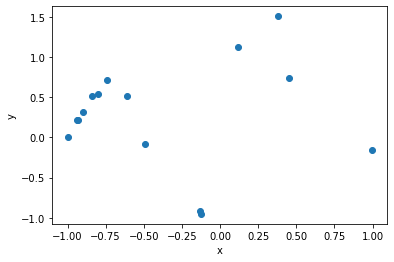

In [45]:
import torch

N = 15
x_data = torch.FloatTensor(N).uniform_(-1, 1)


def true_func(x):
    return 1.5 * torch.exp(x) * torch.sin(2*torch.pi * x)


y_data = true_func(x_data) + 0.05 * torch.randn(N)
# y_data = true_func(x_data) 

plt.scatter(x_data, y_data)
plt.xlabel("x")
plt.ylabel("y")


In [46]:
import gpytorch
from gpytorch.models import ExactGP


In [47]:
# ガウス過程回帰モデルの実装
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # 平均関数
        self.mean_module = gpytorch.means.ConstantMean()
        # カーネル関数
        self.covar_model = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    # ガウス過程の生成過程
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_model(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# 尤度にガウス分布を設定
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# モデルのインスタンス化
model = ExactGPModel(x_data, y_data, likelihood)


Text(0, 0.5, 'loss')

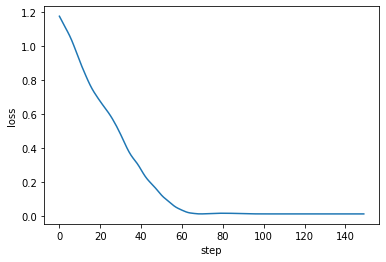

In [48]:
# ハイパーパラメータ学習モードに設定
model.train()
likelihood.train()

# optimizer に adam を設定
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# 周辺対数尤度の計算
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 150
loss_list = []
for i in range(training_iter):
    # 勾配を 0 に初期化
    optimizer.zero_grad()
    # モデルからの出力
    output = model(x_data)
    # 損失関数の計算
    loss = -mll(output, y_data)
    # 勾配計算
    loss.backward()
    # パラメータ更新
    optimizer.step()
    loss_list.append(loss.detach().numpy())

plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("loss")


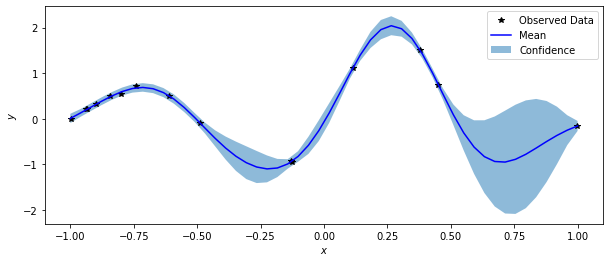

In [49]:
# 推論モードに設定
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # テストデータの用意
    x_new = torch.linspace(-1, 1, 50)
    # 予測分布の出力
    prediction = likelihood(model(x_new))
    # 信用区間の出力
    lower, upper = prediction.confidence_region()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', label='Observed Data')
ax.plot(x_new.numpy(), prediction.mean.numpy(), 'b', label='Mean')
ax.fill_between(x_new.numpy(), lower.numpy(), upper.numpy(),
                alpha=0.5, label='Confidence')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend()
